# Cytopath trajectory analysis with hierarchical clustering

***

Jan T. Schleicher, 2023

Here, we use the Markov chain sampling from Cytopath without specifying an endpoint, followed by hierarchical clustering of sampled cell sequences to identify trajectories in an unbiased way. This allows us to identify convergent trajectories as well.

For this analysis, a novel extension to cytopath, cy2path ([Gupta et al. 2023](https://doi.org/10.1101/2023.08.21.554135)), must be installed with the following steps:
```
pip3 install cy2path==0.0.2
````

If you created a conda environment from the YML file, this should already be installed

In [1]:
import os

import numpy as np
import pandas as pd

import scvelo as scv
import scanpy as sc

import torch
import cy2path as c2p

import cytopath
from cytopath.trajectory_inference import cytopath as cp
from cytopath.trajectory_inference import estimate_cell_data

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.cluster import hierarchy
from dtaidistance import dtw_barycenter

from tqdm.auto import tqdm

np.random.seed(42)
torch.manual_seed(42)

%config Completer.use_jedi = False

In [2]:
DATA_PATH = "../data/"
OUTPUT_PATH = "../output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [3]:
# Import preprocessed data
adata = sc.read_h5ad(os.path.join(DATA_PATH, "tex_data_chronic_annotated.h5ad"))
adata

AnnData object with n_obs × n_vars = 13410 × 7170
    obs: 'sampleID', 'barcode', 'sample_type', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes', 'n_counts', 'phase', 'S_score', 'G2M_score', 'score_diff', 'leiden', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'annot'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mitochondrial', 'ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'cell_cycle_genes', 'gene_count_corr', 'means', 'dispersions',

Iterating state probability distributions:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Tolerance reached after 228 iterations of 1000.


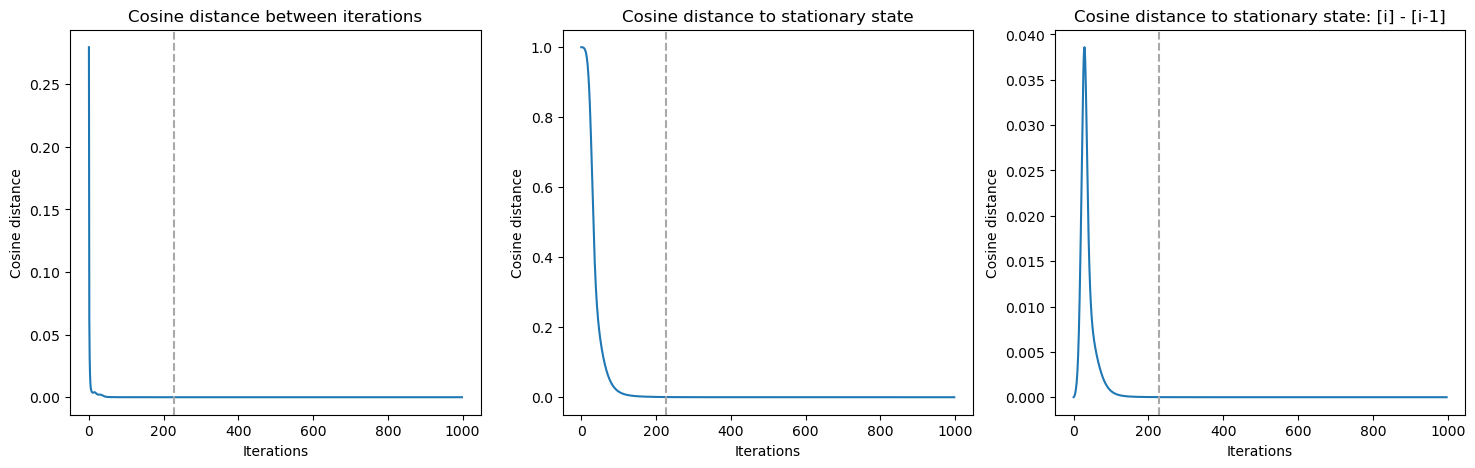

In [4]:
# Run state probability sampling
adata.obsp["T_forward"] = adata.uns["T_forward"]
c2p.sample_state_probability(adata, matrix_key='T_forward',
                             recalc_matrix=False, self_transitions=False)
c2p.plot_distances(adata, log=False)

In [5]:
# Run Markov chain sampling
c2p.cytopath.infer_cytopath_lineages(adata, recalc_items=False,
                                     basis="pca", num_lineages=2,
                                     method="linkage", distance_func="dtw",
                                     differencing=False)

INFO:root:Using precomputed state probability sampling
INFO:root:Sampling Markov chains


Iterating Markov chains:   0%|          | 0/1000 [00:00<?, ? simulations/s]

Storing Markov chains:   0%|          | 0/1000 [00:00<?, ? simulations/s]

Computing empirical state probability distribution:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Clustering the samples.
INFO:be.kuleuven.dtai.distance:Computing n-dim distances
INFO:be.kuleuven.dtai.distance:Compute distances in C (parallel=OMP)


Computing coordinates:   0%|          | 0/2 [00:00<?, ? lineage/s]

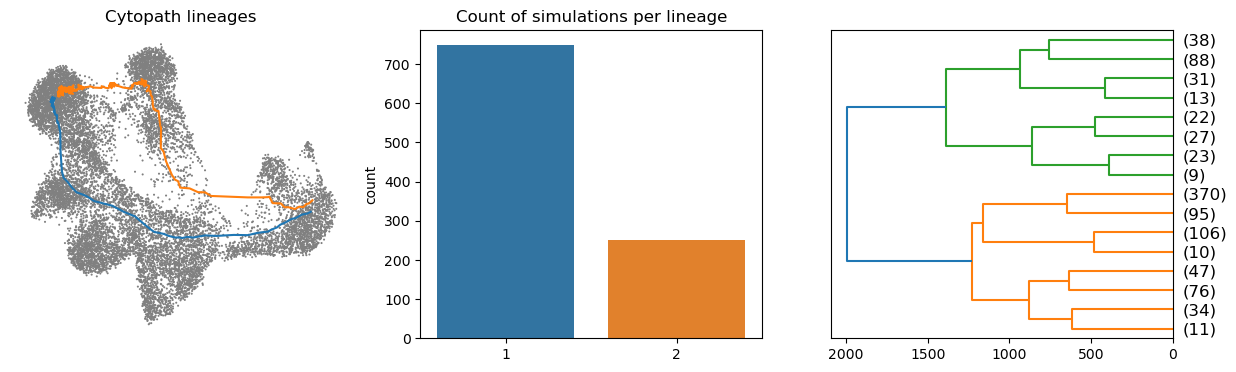

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot lineages
c2p.plot_cytopath_lineages(adata, basis="umap", ax=axs[0])
axs[0].set_title("Cytopath lineages")

# Plot simulation counts per lineage
sns.countplot(x=np.sort(adata.uns["cytopath"]["lineage_inference_clusters"]).astype(str), ax=axs[1])
axs[1].set_title("Count of simulations per lineage")

# Plot dendrogram at default level 3
dendro = hierarchy.dendrogram(adata.uns["cytopath"]["lineage_inference_linkage"], p=3,
                              truncate_mode="level", orientation="left", ax=axs[2])
plt.show()

In [7]:
# Store the trajectories in the format required by cytopath
def save_cytopath_lineages(adata, key=None, basis="umap", mode="average"):
        
    try: assert adata.uns["cytopath"]["lineage_inference_clusters"].shape
    except: raise ValueError("Lineage annotations could not be recovered.")

    # Compute trajectory coordinates
    lineages = [l for l in np.unique(adata.uns["cytopath"]["lineage_inference_clusters"]) if l>=0]
    adata.uns["trajectories"] = {}
    adata.uns["trajectories"]["trajectories_coordinates"] = {"0": {}}
    for i in tqdm(range(len(lineages)), desc="Computing coordinates", unit=" lineage"):
        markov_chain_indices = np.where(adata.uns["cytopath"]["lineage_inference_clusters"]==lineages[i])[0]
        markov_chains_ = adata.uns["markov_chain_sampling"]["state_indices"][markov_chain_indices]

        if mode=="average":
            lineage_coordinate_ = np.median(adata.obsm["X_{}".format(basis)][markov_chains_], axis=0)
        elif mode=="dba":
            lineage_coordinate_ = dtw_barycenter.dba_loop(adata.obsm["X_{}".format(basis)][markov_chains_]\
                                                          .astype("double"), 
                                                 c=None, max_it=1000, use_c=True)
        
        adata.uns["trajectories"]["trajectories_coordinates"]["0"]["trajectory_{}_coordinates".format(i)] = \
            lineage_coordinate_

In [8]:
save_cytopath_lineages(adata)

# Make two separate trajectories for the endpoints to allow fate prediction
adata.uns["trajectories"]["trajectories_coordinates"]["3"] = {}
adata.uns["trajectories"]["trajectories_coordinates"]["3"]["trajectory_0_coordinates"] = \
    adata.uns["trajectories"]["trajectories_coordinates"]["0"]["trajectory_1_coordinates"]
del adata.uns["trajectories"]["trajectories_coordinates"]["0"]["trajectory_1_coordinates"]

Computing coordinates:   0%|          | 0/2 [00:00<?, ? lineage/s]

Computing neighborhoods of trajectories for end point 0 at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  0


  0%|          | 0/228 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  0 (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point 3 at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  3


  0%|          | 0/228 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  3 (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

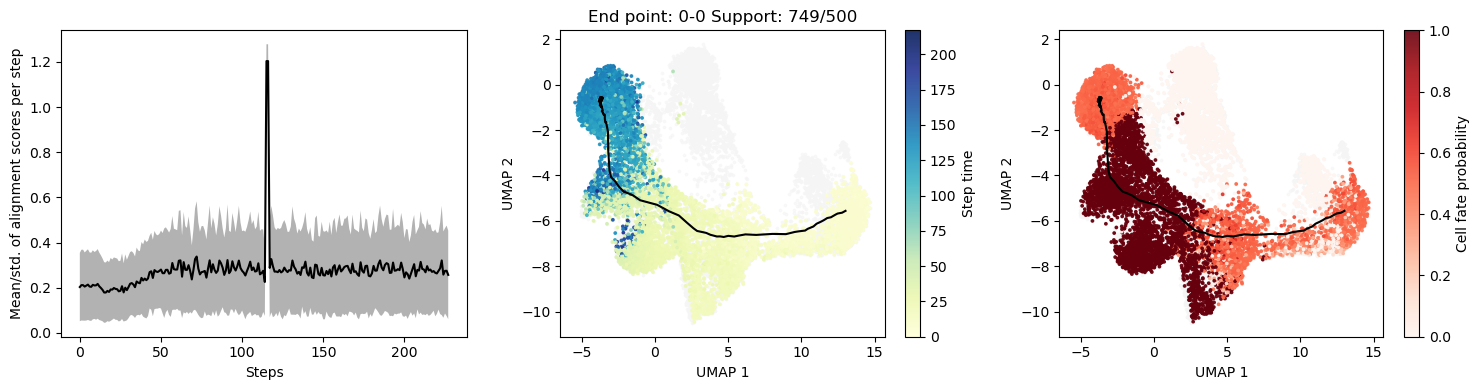

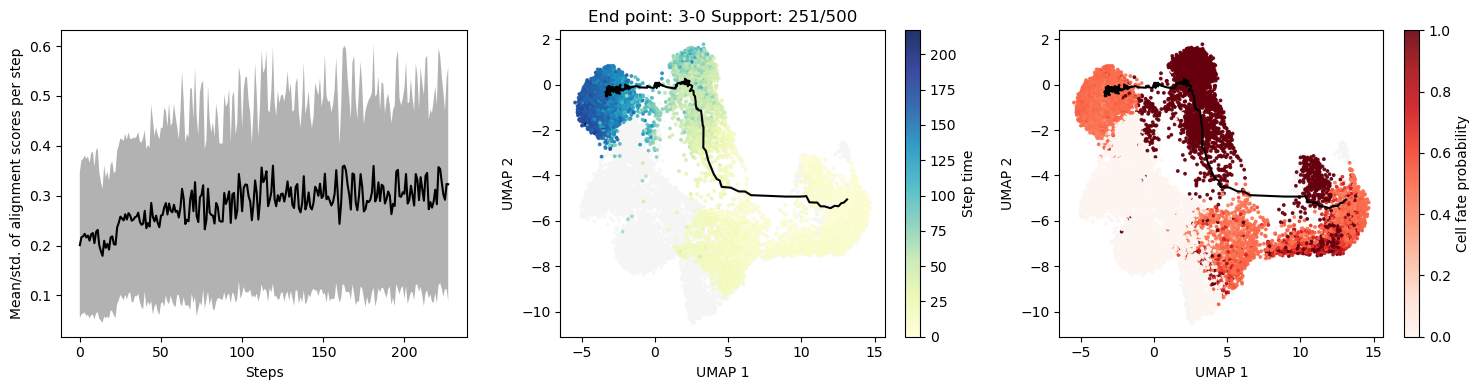

In [9]:
# Use Cytopath trajectory inference
adata.uns["run_info"] = {"cluster_key": "leiden"}
cp(adata, basis="umap", neighbors_basis="pca", surrogate_cell=False,
   fill_cluster=True, cut_off=0.0, num_cores=-1)

estimate_cell_data(adata)

adata.uns["samples"] = {}
adata.uns["samples"]["cell_sequences"] = adata.uns["markov_chain_sampling"]["state_indices"]

adata.uns["run_info"]["end_point_clusters"] = np.array(["0", "3"])
adata.uns["run_info"]["trajectory_count"] = {"0": 1, "3": 1}
traj_sample_counts = np.unique(adata.uns["cytopath"]["lineage_inference_clusters"]\
                               .astype(str), return_counts=True)[1]
adata.uns['run_info']["trajectories_sample_counts"] = {"0": [traj_sample_counts[0]],
                                                       "3": [traj_sample_counts[1]]}
adata.uns['run_info']['projection_basis'] = "umap"

# Plot cytopath trajectories with hierarchically clustered trajectories
cytopath.plot_trajectories(adata, size=3, basis="umap")

In [10]:
# Save results
adata.write_h5ad(os.path.join(DATA_PATH, "tex_data_chronic_cytopath_hierarchical.h5ad"))

INFO:root:Using precomputed state probability sampling
INFO:root:Using precomputed Markov chains
INFO:root:Clustering the samples.
INFO:be.kuleuven.dtai.distance:Computing n-dim distances
INFO:be.kuleuven.dtai.distance:Compute distances in C (parallel=OMP)


Computing coordinates:   0%|          | 0/3 [00:00<?, ? lineage/s]

INFO:root:Using precomputed state probability sampling
INFO:root:Using precomputed Markov chains
INFO:root:Clustering the samples.
INFO:be.kuleuven.dtai.distance:Computing n-dim distances
INFO:be.kuleuven.dtai.distance:Compute distances in C (parallel=OMP)


Computing coordinates:   0%|          | 0/4 [00:00<?, ? lineage/s]

INFO:root:Using precomputed state probability sampling
INFO:root:Using precomputed Markov chains
INFO:root:Clustering the samples.
INFO:be.kuleuven.dtai.distance:Computing n-dim distances
INFO:be.kuleuven.dtai.distance:Compute distances in C (parallel=OMP)


Computing coordinates:   0%|          | 0/5 [00:00<?, ? lineage/s]

INFO:root:Using precomputed state probability sampling
INFO:root:Using precomputed Markov chains
INFO:root:Clustering the samples.
INFO:be.kuleuven.dtai.distance:Computing n-dim distances
INFO:be.kuleuven.dtai.distance:Compute distances in C (parallel=OMP)


Computing coordinates:   0%|          | 0/6 [00:00<?, ? lineage/s]

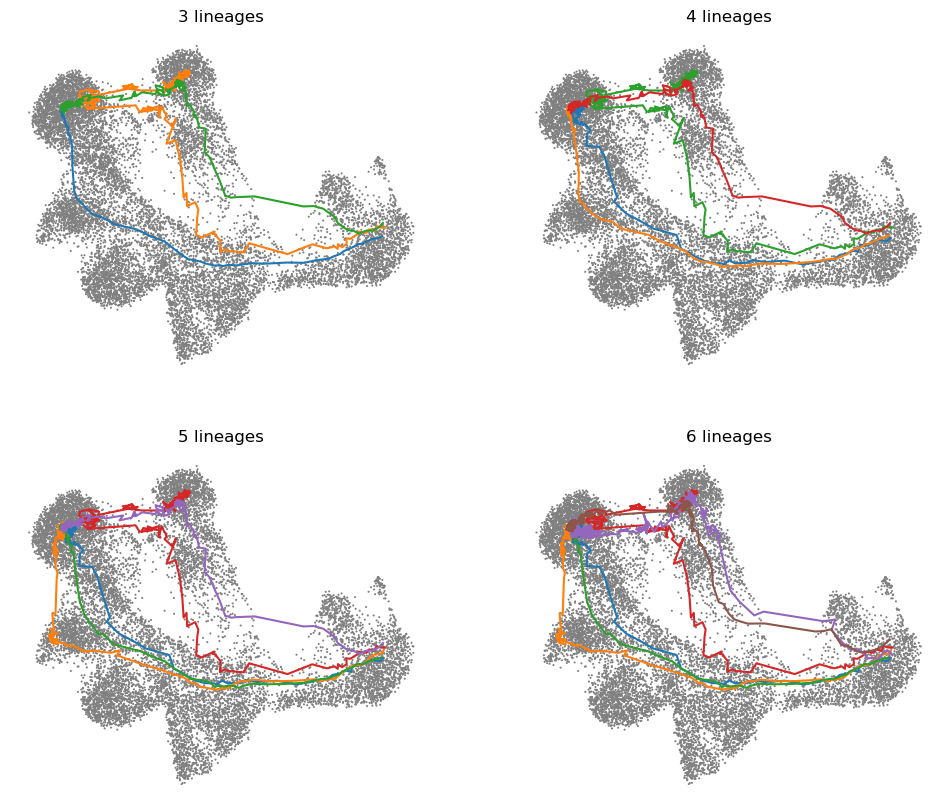

In [11]:
# Perform hierarchical clustering with 3+ lineages and plot lineages
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, n_lineages in enumerate(range(3, 7)):
    adata_ = c2p.cytopath.infer_cytopath_lineages(adata, recalc_items=False,
                                                  basis="pca", num_lineages=n_lineages,
                                                  method="linkage", distance_func="dtw",
                                                  differencing=False, copy=True)
    c2p.plot_cytopath_lineages(adata_, basis="umap", ax=axs.flat[i])
    axs.flat[i].set_title(f"{n_lineages} lineages")